In [274]:
import json
import re

In [413]:
def read_output_file(path, reverse=False):
    # path = "../experiments/somos/ab_testing/diff15_prompt1.txt"
    outputs = []
    with open(path, "r") as f:
        for line in f:
            x = json.loads(line)
            outputs.append(x)
    
    count_all, count_correct = 0, 0
    predictions = []
    for output in outputs:
        if not reverse:
            audio_a, audio_b = output['data']
        else:
            audio_b, audio_a = output['data']
        
        judge_text = output['response']

        # # typo lol
        judge_text = judge_text.replace("</verduct>", "</verdict>")
        judge_text = judge_text.replace("</Verdict>", "</verdict>")
        judge_text = judge_text.replace("</verddict>", "</verdict>")
        judge_text = judge_text.replace("<Verdict>", "<verdict>")
        judge_text = judge_text.replace("<verdict>B</verdict>", "<verdict>[[B]]</verdict>")
        judge_text = judge_text.replace("Verdict: [[A]] </verdict>", "<verdict>[[A]]</verdict>")
        judge_text = judge_text.replace("<verdict> [[Neither]] </verdict>", "<verdict>[[C]]</verdict>")
        judge_text = judge_text.replace("<verdict> [[Cannot Determine]] </verdict>", "<verdict>[[C]]</verdict>")
        judge_text = judge_text.replace("<verdict>[[NA]]</verdict>", "<verdict>[[C]]</verdict>")

        
        # Extract content between <explanation> and </explanation>
        explanation_match = re.search(r'<explanation>(.*?)</explanation>', judge_text, re.DOTALL)
        explanation_text = explanation_match.group(1).strip() if explanation_match else None
        
        # Extract content between <verdict> and </verdict>
        verdict_match = re.search(r'<verdict>(.*?)</verdict>', judge_text, re.DOTALL)
        verdict_text = verdict_match.group(1).strip() if verdict_match else None
        assert verdict_text == "[[A]]" or verdict_text == "[[B]]" or verdict_text == "[[C]]", f"Unexpected verdict: {judge_text}"

        if verdict_text == "[[A]]":
            if audio_a['mos'] > audio_b['mos']:
                count_correct += 1
                evaluation = "correct"
            else:
                evaluation = "incorrect"
        elif verdict_text == "[[B]]":
            if audio_a['mos'] < audio_b['mos']:
                count_correct += 1
                evaluation = "correct"
            else:
                evaluation = "incorrect"
        else:
            evaluation = "incorrect"
        count_all += 1
        
        predictions.append([evaluation, verdict_text, audio_a['mos'], audio_b['mos']])
    print(path)
    print("total:", count_all)
    print("accuracy: {:.2f}%".format(count_correct/count_all*100))
    return predictions

In [418]:
# predictions_ab = read_output_file("../experiments/somos/ab_testing/diff15_prompt2.txt") # ---------------> 74.32%
# predictions_ab = read_output_file("../experiments/somos/ab_testing/diff15_prompt2_sp_sanity.txt") # ---> 73.65%
predictions_ab = read_output_file("../experiments/somos/ab_testing/diff15_prompt2_notext.txt")

../experiments/somos/ab_testing/diff15_prompt2_notext.txt
total: 148
accuracy: 71.62%


In [419]:
# predictions_ba = read_output_file("../experiments/somos/ab_testing/diff15_prompt2_BA.txt", reverse=True)
predictions_ba = read_output_file("../experiments/somos/ab_testing/diff15_prompt2_BA_notext.txt", reverse=True)

../experiments/somos/ab_testing/diff15_prompt2_BA_notext.txt
total: 148
accuracy: 71.62%


In [401]:
# --------------------- Gemini --------------------- #

# predictions_ab = read_output_file("../experiments/somos/ab_testing/diff15_gemini2_prompt1.jsonl0")
predictions_ab = read_output_file("../experiments/somos/ab_testing/diff15_gemini15flash_prompt2.jsonl")
# predictions_ab = read_output_file("../experiments/somos/ab_testing/diff15_gemini2_prompt2.jsonl")

# Reversed BA
# predictions_ba = read_output_file("../experiments/somos/ab_testing/diff15_gemini2_prompt1_BA.jsonl", reverse=True)
predictions_ba = read_output_file("../experiments/somos/ab_testing/diff15_gemini15flash_prompt2_BA.jsonl", reverse=True)
# predictions_ba = read_output_file("../experiments/somos/ab_testing/diff15_gemini2_prompt2_BA.jsonl", reverse=True)

../experiments/somos/ab_testing/diff15_gemini15flash_prompt2.jsonl
total: 148
accuracy: 59.46%
../experiments/somos/ab_testing/diff15_gemini15flash_prompt2_BA.jsonl
total: 148
accuracy: 82.43%


In [420]:
count_A, count_B, count = 0, 0, 0
for x in predictions_ab:
    count += 1
    if x[1] == "[[A]]":
        count_A += 1
    elif x[1] == "[[B]]":
        count_B += 1
    elif x[1] == "[[C]]":
        pass
    else:
        raise Exception()
print("percentage_A: {:.2f}%".format(count_A/count*100))
print("percentage_B: {:.2f}%".format(count_B/count*100))

percentage_A: 54.73%
percentage_B: 45.27%


In [421]:
count_A, count_B, count = 0, 0, 0
for x in predictions_ba:
    count += 1
    if x[1] == "[[A]]":
        count_A += 1
    elif x[1] == "[[B]]":
        count_B += 1
    elif x[1] == "[[C]]":
        pass
    else:
        raise Exception()
print("percentage_A: {:.2f}%".format(count_A/count*100))
print("percentage_B: {:.2f}%".format(count_B/count*100))

percentage_A: 34.46%
percentage_B: 65.54%


In [422]:
count_A, count_B, count = 0, 0, 0
for x in predictions_ab+predictions_ba:
    count += 1
    if x[1] == "[[A]]":
        count_A += 1
    elif x[1] == "[[B]]":
        count_B += 1
    elif x[1] == "[[C]]":
        pass
    else:
        raise Exception()
print("percentage_A: {:.2f}%".format(count_A/count*100))
print("percentage_B: {:.2f}%".format(count_B/count*100))

percentage_A: 44.59%
percentage_B: 55.41%


In [423]:
abba_correct, abba_incorrect = 0, 0
for x in predictions_ab + predictions_ba:
    if x[0] == 'correct':
        abba_correct += 1
    elif x[0] == 'incorrect':
        abba_incorrect += 1
    else:
        raise Exception()
print("total:", abba_correct+abba_incorrect)
print("correct: {:.2f}%".format(abba_correct/(abba_correct+abba_incorrect)*100))
print("incorrect: {:.2f}%".format(abba_incorrect/(abba_correct+abba_incorrect)*100))

total: 296
correct: 71.62%
incorrect: 28.38%


In [424]:
predictions_ab = predictions_ab[:len(predictions_ba)]
consistent, bias_A, bias_B = 0, 0, 0
correct_given_consistent = 0
for ab, ba in zip(predictions_ab, predictions_ba):
    if ab[0] == ba[0]:
        consistent += 1
        if ab[0] == 'correct':
            correct_given_consistent += 1
    else:
        if ab[1] == "[[A]]" and ba[1] == "[[A]]":
            bias_A += 1
        elif ab[1] == "[[B]]" and ba[1] == "[[B]]":
            bias_B += 1
        elif ab[1] == "[[C]]" or ba[1] == "[[C]]":
            pass
        else:
            raise Exception("logic error")
# assert consistent + bias_A + bias_B == len(predictions_ab)
print("error:", len(predictions_ab)-consistent-bias_A-bias_B)  

error: 0


In [426]:
print("consistent: {:.2f}%".format(consistent/len(predictions_ab)*100))
print("bias_A:     {:.2f}%".format(bias_A/len(predictions_ab)*100))
print("bias_B:     {:.2f}%".format(bias_B/len(predictions_ab)*100))
print("P(correct|consistent): {:.2f}%".format(correct_given_consistent/consistent*100))

consistent: 68.92%
bias_A:     10.14%
bias_B:     20.95%
P(correct|consistent): 81.37%


## Full testset

In [431]:
import numpy as np

In [450]:
reverse = False
path = "../experiments/somos/ab_testing/diffall_gemini15flash_prompt2.jsonl"
outputs = []
with open(path, "r") as f:
    for line in f:
        x = json.loads(line)
        outputs.append(x)

count_all, count_correct, error = 0, 0, 0
all_predictions_ab = []
for output in outputs:
    if not reverse:
        audio_a, audio_b = output['data']
    else:
        audio_b, audio_a = output['data']
    mos_diff = np.abs(audio_a['mos'] - audio_b['mos'])
    judge_text = output['response']

    # typo lol
    judge_text = judge_text.replace("</verduct>", "</verdict>")
    judge_text = judge_text.replace("</Verdict>", "</verdict>")
    judge_text = judge_text.replace("</verddict>", "</verdict>")
    judge_text = judge_text.replace("<Verdict>", "<verdict>")
    judge_text = judge_text.replace("<verdict>B</verdict>", "<verdict>[[B]]</verdict>")
    judge_text = judge_text.replace("Verdict: [[A]] </verdict>", "<verdict>[[A]]</verdict>")
    judge_text = judge_text.replace("<verdict> A </verdict>", "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace("<verdict> B </verdict>", "<verdict> [[B]] </verdict>")
    judge_text = judge_text.replace("**verdict** [[A]] **verdict**", "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace("**verdict** [[B]] **verdict**", "<verdict> [[B]] </verdict>")
    judge_text = judge_text.replace("**verdict** A **verdict**", "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace("**verdict** B **verdict**", "<verdict> [[B]] </verdict>")
    judge_text = judge_text.replace('"verdict": "[[A]]"', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('"verdict": "[[B]]"', "<verdict> [[B]] </verdict>")
    # judge_text = judge_text.replace('<verdict> [[Neither]] </verdict>', "<verdict> [[C]] </verdict>")
    # judge_text = judge_text.replace('<verdict> [[Neither A nor B]] </verdict>', "<verdict> [[C]] </verdict>")
    # judge_text = judge_text.replace('<verdict> [[Cannot Determine]] </verdict>', "<verdict> [[C]] </verdict>")
    # judge_text = judge_text.replace('<verdict> [[Cannot determine]] </verdict>', "<verdict> [[C]] </verdict>")
    # judge_text = judge_text.replace('<verdict> [[Insufficient Data]] </verdict>', "<verdict> [[C]] </verdict>")
    # judge_text = judge_text.replace('<verdict> [[Cannot be determined]] </verdict>', "<verdict> [[C]] </verdict>")
    # judge_text = judge_text.replace('<verdict> [[ ]] </verdict>', "<verdict> [[C]] </verdict>")
    # judge_text = judge_text.replace('<verdict> [[Unable to Decide]] </verdict>', "<verdict> [[C]] </verdict>")
    # judge_text = judge_text.replace('<verdict> [[Cannot Decide]] </verdict>', "<verdict> [[C]] </verdict>")

    
    # Extract content between <explanation> and </explanation>
    # explanation_match = re.search(r'<explanation>(.*?)</explanation>', judge_text, re.DOTALL)
    # explanation_text = explanation_match.group(1).strip() if explanation_match else None
    
    # Extract content between <verdict> and </verdict>
    verdict_match = re.search(r'<verdict>(.*?)</verdict>', judge_text, re.DOTALL)
    verdict_text = verdict_match.group(1).strip() if verdict_match else None
    try:
        assert verdict_text == "[[A]]" or verdict_text == "[[B]]", f"Unexpected verdict: {judge_text}"
    except:
        error += 1

    if verdict_text == "[[A]]":
        if audio_a['mos'] > audio_b['mos']:
            count_correct += 1
            evaluation = "correct"
        else:
            evaluation = "incorrect"
    elif verdict_text == "[[B]]":
        if audio_a['mos'] < audio_b['mos']:
            count_correct += 1
            evaluation = "correct"
        else:
            evaluation = "incorrect"
    else:
        evaluation = "incorrect"
    count_all += 1
    
    all_predictions_ab.append([evaluation, verdict_text, mos_diff])
print("total:", count_all)
print("accuracy: {:.2f}%".format(count_correct/count_all*100))

total: 3567
accuracy: 51.14%


In [451]:
reverse = True
path = "../experiments/somos/ab_testing/diffall_prompt2_BA.txt"
outputs = []
with open(path, "r") as f:
    for line in f:
        x = json.loads(line)
        outputs.append(x)

count_all, count_correct, error = 0, 0, 0
all_predictions_ba = []
for output in outputs:
    if not reverse:
        audio_a, audio_b = output['data']
    else:
        audio_b, audio_a = output['data']
    mos_diff = np.abs(audio_a['mos'] - audio_b['mos'])
    judge_text = output['response']

    # typo lol
    judge_text = judge_text.replace("</verduct>", "</verdict>")
    judge_text = judge_text.replace("</Verdict>", "</verdict>")
    judge_text = judge_text.replace("</verddict>", "</verdict>")
    judge_text = judge_text.replace("<Verdict>", "<verdict>")
    judge_text = judge_text.replace("<verdict>B</verdict>", "<verdict>[[B]]</verdict>")
    judge_text = judge_text.replace("Verdict: [[A]] </verdict>", "<verdict>[[A]]</verdict>")
    judge_text = judge_text.replace("<verdict> A </verdict>", "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace("<verdict> B </verdict>", "<verdict> [[B]] </verdict>")
    judge_text = judge_text.replace("**verdict** [[A]] **verdict**", "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace("**verdict** [[B]] **verdict**", "<verdict> [[B]] </verdict>")
    judge_text = judge_text.replace("**verdict** A **verdict**", "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace("**verdict** B **verdict**", "<verdict> [[B]] </verdict>")
    judge_text = judge_text.replace('"verdict": "[[A]]"', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('"verdict": "[[B]]"', "<verdict> [[B]] </verdict>")

    
    # Extract content between <explanation> and </explanation>
    # explanation_match = re.search(r'<explanation>(.*?)</explanation>', judge_text, re.DOTALL)
    # explanation_text = explanation_match.group(1).strip() if explanation_match else None
    
    # Extract content between <verdict> and </verdict>
    verdict_match = re.search(r'<verdict>(.*?)</verdict>', judge_text, re.DOTALL)
    verdict_text = verdict_match.group(1).strip() if verdict_match else None
    try:
        assert verdict_text == "[[A]]" or verdict_text == "[[B]]", f"Unexpected verdict: {judge_text}"
    except:
        error += 1
        
    if verdict_text == "[[A]]":
        if audio_a['mos'] > audio_b['mos']:
            count_correct += 1
            evaluation = "correct"
        else:
            evaluation = "incorrect"
    elif verdict_text == "[[B]]":
        if audio_a['mos'] < audio_b['mos']:
            count_correct += 1
            evaluation = "correct"
        else:
            evaluation = "incorrect"
    else:
        evaluation = "incorrect"
        
    count_all += 1
    
    all_predictions_ba.append([evaluation, verdict_text, mos_diff])
print("total:", count_all)
print("accuracy: {:.2f}%".format(count_correct/count_all*100))
print("error:    {:.2f}%".format(error/count_all*100))

total: 3567
accuracy: 59.27%
error:    0.00%


In [452]:
# prompt2 (CoT, instruction in system, two audio in separate user turns, ref_text provided)
# tihs is the setup for all test samples

In [453]:
some_predictions_ab, some_predictions_ba = [], []
for x, y in zip(all_predictions_ab, all_predictions_ba):
    # mos diff
    assert x[2] == y[2]
    mos_diff = x[2]
    # if 0.50 < mos_diff and mos_diff <= 0.75:
    # if 0.75 < mos_diff and mos_diff <= 1.00:
    # if 1.00 < mos_diff and mos_diff <= 1.25:
    # if 1.25 < mos_diff and mos_diff <= 1.50:
    # if 1.50 < mos_diff:
    if 0.00 < mos_diff:
        pass
    else:
        continue
    some_predictions_ab.append(x)
    some_predictions_ba.append(y)
print(len(some_predictions_ab), len(some_predictions_ba)) 

3567 3567


In [455]:
abba_correct, abba_incorrect = 0, 0
for x in some_predictions_ab + some_predictions_ba:
    if x[0] == 'correct':
        abba_correct += 1
    elif x[0] == 'incorrect':
        abba_incorrect += 1
    else:
        raise Exception()
print("total:", abba_correct+abba_incorrect)
print("correct: {:.2f}%".format(abba_correct/(abba_correct+abba_incorrect)*100))
print("incorrect: {:.2f}%".format(abba_incorrect/(abba_correct+abba_incorrect)*100))

total: 7134
correct: 55.20%
incorrect: 44.80%


In [135]:
np.mean([x[2] for x in some_predictions_ab + some_predictions_ba])

1.809036309036309

In [456]:
consistent, bias_A, bias_B = 0, 0, 0
correct_given_consistent = 0
for ab, ba in zip(some_predictions_ab, some_predictions_ba):
    if ab[0] == ba[0]:
        consistent += 1
        if ab[0] == 'correct':
            correct_given_consistent += 1
    else:
        if ab[1] == "[[A]]" and ba[1] == "[[A]]":
            bias_A += 1
        elif ab[1] == "[[B]]" and ba[1] == "[[B]]":
            bias_B += 1
        else:
            raise Exception("logic error")
assert consistent + bias_A + bias_B == len(some_predictions_ab)
print("consistent: {:.2f}%".format(consistent/len(some_predictions_ab)*100))
print("bias_A:     {:.2f}%".format(bias_A/len(some_predictions_ab)*100))
print("bias_B:     {:.2f}%".format(bias_B/len(some_predictions_ab)*100))
print("P(correct|consistent): {:.2f}%".format(correct_given_consistent/consistent*100))

Exception: logic error

In [140]:
import matplotlib.pyplot as plt

In [139]:
mos_diff_avg = [0.125, 0.375, 0.625, 0.875, 1.125, 1.375, 1.809]
accuracy = [51.65, 56.03, 56.71, 64.02, 67.53, 70.40, 76.01]

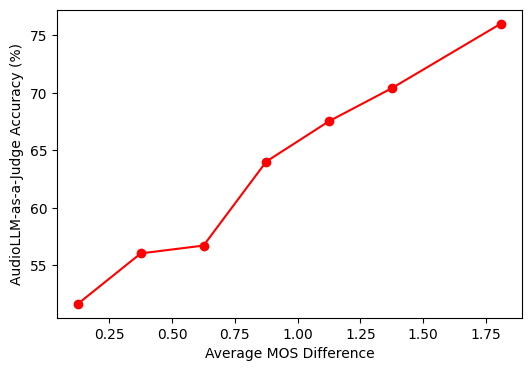

In [146]:
plt.figure(figsize=(6, 4))
plt.plot(mos_diff_avg, accuracy, 'o-', color='red')
plt.xlabel('Average MOS Difference')
plt.ylabel('AudioLLM-as-a-Judge Accuracy (%)')
# plt.legend()
# plt.grid()
plt.show()

## System-level Analysis

In [457]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [458]:
def post_processing(judge_text):
    judge_text = judge_text.replace("</verduct>", "</verdict>")
    judge_text = judge_text.replace("</Verdict>", "</verdict>")
    judge_text = judge_text.replace("</verddict>", "</verdict>")
    judge_text = judge_text.replace("<Verdict>", "<verdict>")
    judge_text = judge_text.replace("<verdict>B</verdict>", "<verdict>[[B]]</verdict>")
    judge_text = judge_text.replace("Verdict: [[A]] </verdict>", "<verdict>[[A]]</verdict>")
    judge_text = judge_text.replace("<verdict> A </verdict>", "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace("<verdict> B </verdict>", "<verdict> [[B]] </verdict>")
    judge_text = judge_text.replace("**verdict** [[A]] **verdict**", "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace("**verdict** [[B]] **verdict**", "<verdict> [[B]] </verdict>")
    judge_text = judge_text.replace("**verdict** A **verdict**", "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace("**verdict** B **verdict**", "<verdict> [[B]] </verdict>")
    judge_text = judge_text.replace('"verdict": "[[A]]"', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('"verdict": "[[B]]"', "<verdict> [[B]] </verdict>")
    return judge_text

In [164]:
def analyze_correlation_and_plot(list_a, list_b):
    # 1. Compute Pearson correlation
    pearson_corr, _ = stats.pearsonr(list_a, list_b)

    # 2. Compute Spearman correlation
    spearman_corr, _ = stats.spearmanr(list_a, list_b)

    # Print results
    print(f"Pearson Correlation: {pearson_corr:.3f}")
    print(f"Spearman Correlation: {spearman_corr:.3f}")

    # 4. Scatter plot with best-fit line
    plt.figure(figsize=(5, 4))
    plt.scatter(list_a, list_b, color='blue', label='Data points')

    # Best fit line
    coefficients = np.polyfit(list_a, list_b, 1)  # Linear fit (degree=1)
    poly = np.poly1d(coefficients)
    best_fit_line = poly(list_a)

    plt.plot(list_a, best_fit_line, color='red', label='Best Fit Line')
    plt.xlabel('MOS (GT)')
    plt.ylabel('AudioJudge Prediction (Win Rate)')
    plt.title('Scatter Plot with Best Fit Line')
    plt.legend()
    plt.grid()
    plt.show()

Pearson Correlation: 0.391
Spearman Correlation: 0.394


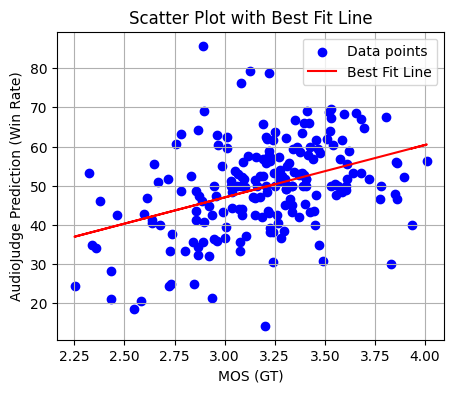

In [464]:
# def evaluate_system_level():
pred_by_system, gts_by_system = {}, {}
criterion = 'mos'
reverse = False
path = "../experiments/somos/ab_testing/diffall_gemini15flash_prompt2.jsonl"
outputs = []
with open(path, "r") as f:
    for line in f:
        x = json.loads(line)
        outputs.append(x)
for output in outputs:
    audio_a, audio_b = output['data']
    model_a = audio_a['uttId'].split('_')[-1]
    model_b = audio_b['uttId'].split('_')[-1]
    if model_a not in pred_by_system: pred_by_system[model_a] = []
    if model_a not in gts_by_system:  gts_by_system[model_a] = []
    if model_b not in pred_by_system: pred_by_system[model_b] = []
    if model_b not in gts_by_system:  gts_by_system[model_b] = []
        
    judge_text = output['response']
    judge_text = post_processing(judge_text)
    
    # Extract content between <verdict> and </verdict>
    verdict_match = re.search(r'<verdict>(.*?)</verdict>', judge_text, re.DOTALL)
    verdict_text = verdict_match.group(1).strip() if verdict_match else None
    try:
        assert verdict_text == "[[A]]" or verdict_text == "[[B]]", f"Unexpected verdict: {judge_text}"
    except:
        # error -- just make it wrong
        # print("warning:", judge_text)
        if audio_a[criterion] > audio_b[criterion]: verdict_text = '[[B]]'
        else: verdict_text = '[[A]]'
        
    if verdict_text == "[[A]]":
        pred_by_system[model_a] += [1]
        pred_by_system[model_b] += [0]
    elif verdict_text == "[[B]]":
        pred_by_system[model_a] += [0]
        pred_by_system[model_b] += [1]

    gts_by_system[model_a] += [audio_a['mos']]
    gts_by_system[model_b] += [audio_b['mos']]

reverse = True
path = "../experiments/somos/ab_testing/diffall_gemini15flash_prompt2_BA.jsonl"
outputs = []
with open(path, "r") as f:
    for line in f:
        x = json.loads(line)
        outputs.append(x)
for output in outputs:
    audio_b, audio_a = output['data']
    model_a = audio_a['uttId'].split('_')[-1]
    model_b = audio_b['uttId'].split('_')[-1]
    
    judge_text = output['response']
    judge_text = post_processing(judge_text)
    
    # Extract content between <verdict> and </verdict>
    verdict_match = re.search(r'<verdict>(.*?)</verdict>', judge_text, re.DOTALL)
    verdict_text = verdict_match.group(1).strip() if verdict_match else None
    try:
        assert verdict_text == "[[A]]" or verdict_text == "[[B]]", f"Unexpected verdict: {judge_text}"
    except:
        # error -- just make it wrong
        # print("warning:", judge_text)
        if audio_a[criterion] > audio_b[criterion]: verdict_text = '[[B]]'
        else: verdict_text = '[[A]]'
        
    if verdict_text == "[[A]]":
        pred_by_system[model_a] += [1]
        pred_by_system[model_b] += [0]
    elif verdict_text == "[[B]]":
        pred_by_system[model_a] += [0]
        pred_by_system[model_b] += [1]

    gts_by_system[model_a] += [audio_a['mos']]
    gts_by_system[model_b] += [audio_b['mos']]

system_level_pred, system_level_gts = [], []
systems = []
for system, pred in pred_by_system.items():
    gts = gts_by_system[system]
    assert len(pred) == len(gts)
    system_level_pred.append(np.mean(pred)*100)
    system_level_gts.append(np.mean(gts))
    systems.append(system)
analyze_correlation_and_plot(system_level_gts, system_level_pred)

# Qwen2-Audio

In [480]:
from tqdm import tqdm

In [466]:
def read_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            try:
                data.append(json.loads(line.strip()))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e} on line: {line}")
    return data

In [488]:
count_all, count_correct, error = 0, 0, 0
all_predictions_ab = []

reverse = False
outputs = read_jsonl("../experiments/somos/ab_testing/diffall_qwen2_prompt2_format1.processed.txt")
for output in tqdm(outputs):
    if not reverse:
        audio_a, audio_b = output['data']
    else:
        audio_b, audio_a = output['data']
    mos_diff = np.abs(audio_a['mos'] - audio_b['mos'])
    verdict_text = output['processed']

    try:
        assert verdict_text == "A" or verdict_text == "B" or verdict_text == "C", f"Unexpected verdict: {judge_text}"
    except:
        error += 1

    if verdict_text == "A":
        if audio_a['mos'] > audio_b['mos']:
            count_correct += 1
            evaluation = "correct"
        else:
            evaluation = "incorrect"
        # count_all += 1
    elif verdict_text == "B":
        if audio_a['mos'] < audio_b['mos']:
            count_correct += 1
            evaluation = "correct"
        else:
            evaluation = "incorrect"
        # count_all += 1
    else:
        evaluation = "incorrect"
    count_all += 1
    
    all_predictions_ab.append([evaluation, verdict_text, mos_diff])

reverse = True
outputs = read_jsonl("../experiments/somos/ab_testing/diffall_qwen2_prompt2_format1_noref..processed.txt")
for output in tqdm(outputs):
    if not reverse:
        audio_a, audio_b = output['data']
    else:
        audio_b, audio_a = output['data']
    mos_diff = np.abs(audio_a['mos'] - audio_b['mos'])
    verdict_text = output['processed']

    try:
        assert verdict_text == "A" or verdict_text == "B" or verdict_text == "C", f"Unexpected verdict: {judge_text}"
    except:
        error += 1

    if verdict_text == "A":
        if audio_a['mos'] > audio_b['mos']:
            count_correct += 1
            evaluation = "correct"
        else:
            evaluation = "incorrect"
        # count_all += 1
    elif verdict_text == "B":
        if audio_a['mos'] < audio_b['mos']:
            count_correct += 1
            evaluation = "correct"
        else:
            evaluation = "incorrect"
        # count_all += 1
    else:
        evaluation = "incorrect"
    count_all += 1
    
    all_predictions_ab.append([evaluation, verdict_text, mos_diff])


print("total:", count_all)
print("accuracy: {:.2f}%".format(count_correct/count_all*100))    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3567/3567 [00:00<00:00, 593623.08it/s]

total: 3567
accuracy: 25.51%


In [ ]:
# 25.51 ===> overall accuracy
# 51.21 ===> accuracy given it answers A or B

In [475]:
output

{'model_name': 'gemini-1.5-flash',
 'data_path': '/data/workspace/ppotsawee/audioLM-as-judge/data/data_somos_pairwise_diffall.json',
 'data': [{'uttId': 'LJ003-0173_007',
   'mos': 3.4,
   'text': 'He continued the ancient practice of letting out a portion of his own house, and by a poetical fiction treated it, as an annex of the state side.',
   'path': '/data/share/data/Speech/somos/audios/LJ003-0173_007.wav'},
  {'uttId': 'LJ003-0173_166',
   'mos': 3.0,
   'text': 'He continued the ancient practice of letting out a portion of his own house, and by a poetical fiction treated it, as an annex of the state side.',
   'path': '/data/share/data/Speech/somos/audios/LJ003-0173_166.wav'}],
 'prompt_text': 'You are an expert in audio quality assessment specializing in synthesized speech evaluation. Your task is to critically compare two audio files, the first audio (Audio A) and the second audio (Audio B), will be provided after this instruction. The evaluation is based on the following crit

In [469]:
x[0]

{'data_path': 'data/data_somos_pairwise_diffall.json',
 'data': [{'uttId': 'LJ003-0173_007',
   'mos': 3.4,
   'text': 'He continued the ancient practice of letting out a portion of his own house, and by a poetical fiction treated it, as an annex of the state side.',
   'path': '/data/share/data/Speech/somos/audios/LJ003-0173_007.wav'},
  {'uttId': 'LJ003-0173_166',
   'mos': 3.0,
   'text': 'He continued the ancient practice of letting out a portion of his own house, and by a poetical fiction treated it, as an annex of the state side.',
   'path': '/data/share/data/Speech/somos/audios/LJ003-0173_166.wav'}],
 'prompt_text': 'You are an expert in audio quality assessment specializing in synthesized speech evaluation. Your task is to critically compare two audio files, the first audio (Audio A) and the second audio (Audio B), will be provided after this instruction. The evaluation is based on the following criteria:\n\n1.\tClarity: How clearly the speech is articulated, free from distort

# Other baselines
- UTMOS, MOSANET+

In [173]:
import pandas as pd

In [184]:
baseline = pd.read_csv("../experiments/eval-somos_cleaned_test_mos.csv")
baseline_results = {}
for i in range(len(baseline)):
    x = baseline.iloc[i]
    uttId = x['utteranceId'].replace(".wav", "")
    baseline_results[uttId] = x

In [188]:
baseline

,utteranceId,mean,mosanet_q,mosanet_i,utmos
0,LJ002-0181_110.wav,4.000000,4.143179,0.987690,4.238315
1,LJ002-0181_148.wav,4.000000,4.279014,0.991089,4.000192
2,LJ003-0083_177.wav,3.727273,4.255704,0.992737,4.085151
3,LJ003-0173_007.wav,3.400000,4.203598,0.990003,3.985967
4,LJ003-0173_166.wav,3.000000,4.195775,0.990287,3.545846
...,...,...,...,...,...
2995,wiki_0096_105.wav,3.714286,4.198464,0.991320,4.211437
2996,wiki_0097_061.wav,3.100000,3.862368,0.980607,3.472677
2997,wiki_0098_115.wav,2.000000,3.549011,0.975410,3.402414
2998,wiki_0098_124.wav,2.333333,3.595597,0.978362,3.503975


In [430]:
path = "../experiments/somos/ab_testing/diffall_prompt2.txt"
outputs = []
with open(path, "r") as f:
    for line in f:
        x = json.loads(line)
        outputs.append(x)

baseline_name = 'utmos'

count_all, count_correct = 0, 0
for output in outputs:
    audio_a, audio_b = output['data']
    mos_a, mos_b = audio_a['mos'], audio_b['mos']
    if mos_a == mos_b: continue
    
    baseline_a = baseline_results[audio_a['uttId']][baseline_name]
    baseline_b = baseline_results[audio_b['uttId']][baseline_name]

    if mos_a >= mos_b:
        if baseline_a >= baseline_b:
            count_correct += 1
    else:
        if baseline_b > baseline_a:
            count_correct += 1
    count_all += 1
print("total:", count_all)
print("correct: {:.2f}%".format(count_correct/(count_all)*100))

total: 3567
correct: 64.56%


### System-level

Pearson Correlation: 0.616
Spearman Correlation: 0.665


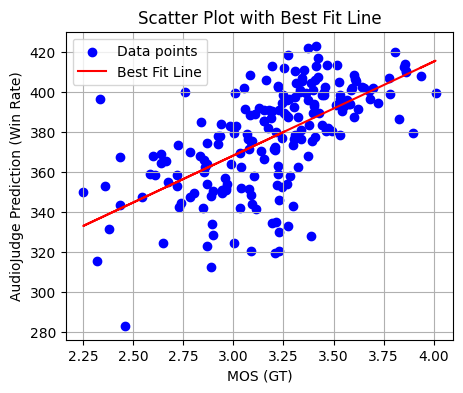

In [428]:
# def evaluate_system_level():
pred_by_system, gts_by_system = {}, {}

path = "../experiments/somos/ab_testing/diffall_prompt2.txt"
outputs = []
with open(path, "r") as f:
    for line in f:
        x = json.loads(line)
        outputs.append(x)

baseline_name = 'utmos'

for output in outputs:
    audio_a, audio_b = output['data']
    model_a = audio_a['uttId'].split('_')[-1]
    model_b = audio_b['uttId'].split('_')[-1]
    if model_a not in pred_by_system: pred_by_system[model_a] = []
    if model_a not in gts_by_system:  gts_by_system[model_a] = []
    if model_b not in pred_by_system: pred_by_system[model_b] = []
    if model_b not in gts_by_system:  gts_by_system[model_b] = []
        
    baseline_a = baseline_results[audio_a['uttId']][baseline_name]
    baseline_b = baseline_results[audio_b['uttId']][baseline_name]

    pred_by_system[model_a] += [baseline_a]
    pred_by_system[model_b] += [baseline_b]
    
    gts_by_system[model_a] += [audio_a['mos']]
    gts_by_system[model_b] += [audio_b['mos']]

system_level_pred, system_level_gts = [], []
systems = []
for system, pred in pred_by_system.items():
    gts = gts_by_system[system]
    assert len(pred) == len(gts)
    system_level_pred.append(np.mean(pred)*100)
    system_level_gts.append(np.mean(gts))
    systems.append(system)
analyze_correlation_and_plot(system_level_gts, system_level_pred)